# Pizza I4 Architecture - Production Experiment Analysis
This notebook analyzes order and pizza production data to identify performance patterns and bottlenecks.

In [1]:
!pip install pandas numpy matplotlib seaborn scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


## 1. Data Loading and Preparation

In [2]:
# Load data
order_df = pd.read_csv('order-data.csv')
pizza_df = pd.read_csv('pizza-data.csv')

print(f"Original Orders: {len(order_df)}")
print(f"Original Pizzas: {len(pizza_df)}")

# Convert timestamps
for df in [order_df, pizza_df]:
    df['START_TIME'] = pd.to_datetime(df['STARTTIMESTAMP'], unit='ms')
    df['END_TIME'] = pd.to_datetime(df['ENDTIMESTAMP'], unit='ms', errors='coerce')
    
# Calculate latency in seconds
order_df['LATENCY_S'] = (order_df['END_TIME'] - order_df['START_TIME']).dt.total_seconds()
pizza_df['LATENCY_S'] = (pizza_df['END_TIME'] - pizza_df['START_TIME']).dt.total_seconds()

# Separate completed and incomplete
completed_orders = order_df.dropna(subset=['END_TIME']).copy()
incomplete_orders = order_df[order_df['END_TIME'].isna()].copy()

completed_pizzas = pizza_df.dropna(subset=['END_TIME']).copy()
incomplete_pizzas = pizza_df[pizza_df['END_TIME'].isna()].copy()

print(f"\nCompleted Orders: {len(completed_orders)} ({len(completed_orders)/len(order_df)*100:.1f}%)")
print(f"Incomplete Orders: {len(incomplete_orders)} ({len(incomplete_orders)/len(order_df)*100:.1f}%)")
print(f"\nCompleted Pizzas: {len(completed_pizzas)} ({len(completed_pizzas)/len(pizza_df)*100:.1f}%)")
print(f"Incomplete Pizzas: {len(incomplete_pizzas)} ({len(incomplete_pizzas)/len(pizza_df)*100:.1f}%)")

Original Orders: 9
Original Pizzas: 1067

Completed Orders: 7 (77.8%)
Incomplete Orders: 2 (22.2%)

Completed Pizzas: 1057 (99.1%)
Incomplete Pizzas: 10 (0.9%)


## 2. Order-Level Analysis

In [3]:
# Summary statistics
print("=" * 60)
print("ORDER LATENCY STATISTICS (Completed Orders Only)")
print("=" * 60)
print(f"\nMean: {completed_orders['LATENCY_S'].mean():.2f}s")
print(f"Median: {completed_orders['LATENCY_S'].median():.2f}s")
print(f"Std Dev: {completed_orders['LATENCY_S'].std():.2f}s")
print(f"Min: {completed_orders['LATENCY_S'].min():.2f}s")
print(f"Max: {completed_orders['LATENCY_S'].max():.2f}s")

# Percentiles
percentiles = [25, 50, 75, 90, 95, 99]
print("\nPercentiles:")
for p in percentiles:
    val = np.percentile(completed_orders['LATENCY_S'], p)
    print(f"  P{p}: {val:.2f}s")

# Group by order size
print("\n" + "=" * 60)
print("LATENCY BY ORDER SIZE")
print("=" * 60)
size_analysis = completed_orders.groupby('ORDERSIZE').agg({
    'LATENCY_S': ['count', 'mean', 'median', 'std', 'min', 'max']
}).round(2)
size_analysis.columns = ['Count', 'Mean(s)', 'Median(s)', 'Std(s)', 'Min(s)', 'Max(s)']
print(size_analysis)

ORDER LATENCY STATISTICS (Completed Orders Only)

Mean: 443.31s
Median: 174.13s
Std Dev: 564.91s
Min: 22.86s
Max: 1573.41s

Percentiles:
  P25: 99.52s
  P50: 174.13s
  P75: 566.88s
  P90: 1111.92s
  P95: 1342.67s
  P99: 1527.26s

LATENCY BY ORDER SIZE
           Count  Mean(s)  Median(s)  Std(s)   Min(s)   Max(s)
ORDERSIZE                                                     
3              1    22.86      22.86     NaN    22.86    22.86
6              1    33.25      33.25     NaN    33.25    33.25
50             2   169.96     169.96     5.9   165.79   174.13
100            1   329.50     329.50     NaN   329.50   329.50
250            1   804.26     804.26     NaN   804.26   804.26
500            1  1573.41    1573.41     NaN  1573.41  1573.41


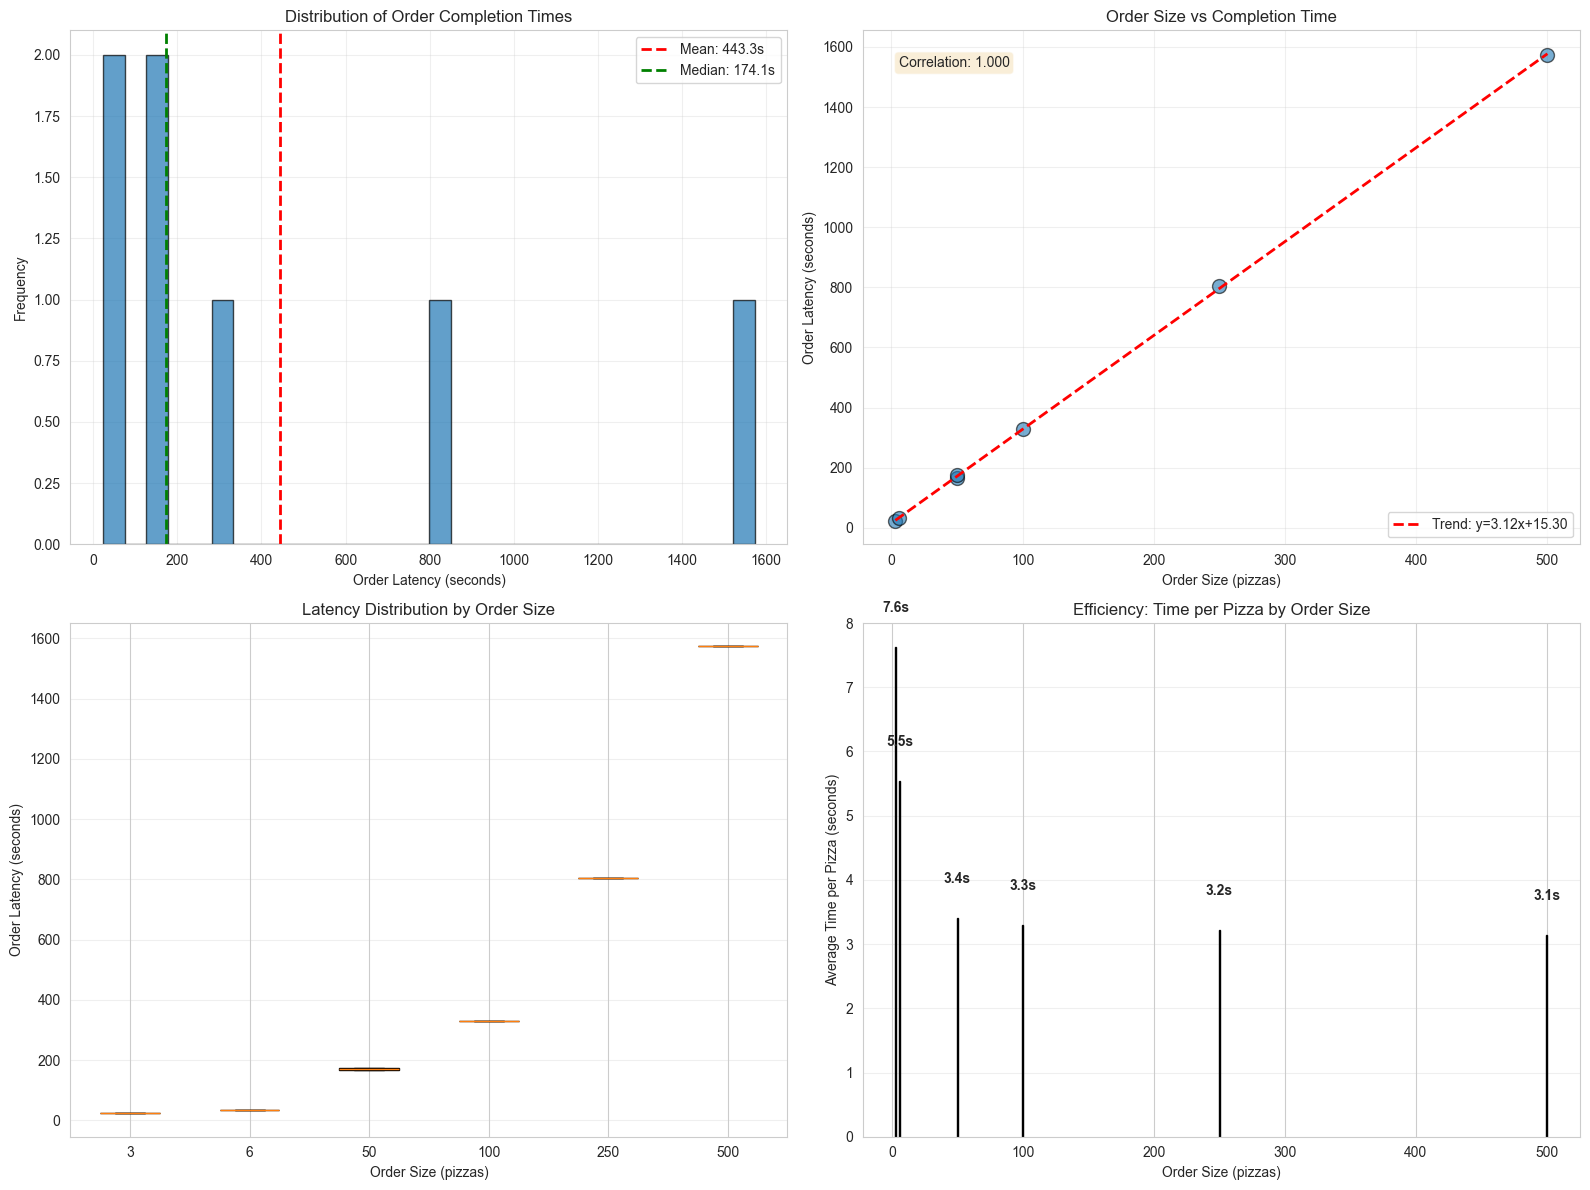

✓ Saved: order_analysis_comprehensive.png


In [4]:
# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Distribution of order latency
axes[0, 0].hist(completed_orders['LATENCY_S'], bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(completed_orders['LATENCY_S'].mean(), color='red', 
                   linestyle='--', linewidth=2, label=f'Mean: {completed_orders["LATENCY_S"].mean():.1f}s')
axes[0, 0].axvline(completed_orders['LATENCY_S'].median(), color='green', 
                   linestyle='--', linewidth=2, label=f'Median: {completed_orders["LATENCY_S"].median():.1f}s')
axes[0, 0].set_xlabel('Order Latency (seconds)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Order Completion Times')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Order size vs latency (scatter with trend)
axes[0, 1].scatter(completed_orders['ORDERSIZE'], completed_orders['LATENCY_S'], 
                   alpha=0.6, s=100, edgecolors='black')
z = np.polyfit(completed_orders['ORDERSIZE'], completed_orders['LATENCY_S'], 1)
p = np.poly1d(z)
x_line = np.linspace(completed_orders['ORDERSIZE'].min(), completed_orders['ORDERSIZE'].max(), 100)
axes[0, 1].plot(x_line, p(x_line), "r--", linewidth=2, label=f'Trend: y={z[0]:.2f}x+{z[1]:.2f}')
axes[0, 1].set_xlabel('Order Size (pizzas)')
axes[0, 1].set_ylabel('Order Latency (seconds)')
axes[0, 1].set_title('Order Size vs Completion Time')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Calculate correlation
corr = completed_orders['ORDERSIZE'].corr(completed_orders['LATENCY_S'])
axes[0, 1].text(0.05, 0.95, f'Correlation: {corr:.3f}', 
                transform=axes[0, 1].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 3. Box plot by order size
order_sizes_sorted = sorted(completed_orders['ORDERSIZE'].unique())
data_for_box = [completed_orders[completed_orders['ORDERSIZE'] == size]['LATENCY_S'] 
                for size in order_sizes_sorted]
bp = axes[1, 0].boxplot(data_for_box, labels=order_sizes_sorted, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
axes[1, 0].set_xlabel('Order Size (pizzas)')
axes[1, 0].set_ylabel('Order Latency (seconds)')
axes[1, 0].set_title('Latency Distribution by Order Size')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Average latency per pizza by order size
completed_orders['LATENCY_PER_PIZZA'] = completed_orders['LATENCY_S'] / completed_orders['ORDERSIZE']
avg_per_pizza = completed_orders.groupby('ORDERSIZE')['LATENCY_PER_PIZZA'].mean()
axes[1, 1].bar(avg_per_pizza.index, avg_per_pizza.values, color='coral', edgecolor='black')
axes[1, 1].set_xlabel('Order Size (pizzas)')
axes[1, 1].set_ylabel('Average Time per Pizza (seconds)')
axes[1, 1].set_title('Efficiency: Time per Pizza by Order Size')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Add values on bars
for i, v in enumerate(avg_per_pizza.values):
    axes[1, 1].text(avg_per_pizza.index[i], v + 0.5, f'{v:.1f}s', 
                    ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('order_analysis_comprehensive.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: order_analysis_comprehensive.png")

## 3. Pizza-Level Analysis

In [5]:
# Merge pizza data with order size
pizza_enriched = completed_pizzas.merge(
    order_df[['ORDERID', 'ORDERSIZE']], 
    left_on='S_ORDER_ID', 
    right_on='ORDERID',
    how='left'
)

print("=" * 60)
print("PIZZA LATENCY STATISTICS")
print("=" * 60)
print(f"\nMean: {pizza_enriched['LATENCY_S'].mean():.2f}s")
print(f"Median: {pizza_enriched['LATENCY_S'].median():.2f}s")
print(f"Std Dev: {pizza_enriched['LATENCY_S'].std():.2f}s")
print(f"Min: {pizza_enriched['LATENCY_S'].min():.2f}s")
print(f"Max: {pizza_enriched['LATENCY_S'].max():.2f}s")

# Analysis by order size
print("\n" + "=" * 60)
print("PIZZA LATENCY BY ORDER SIZE")
print("=" * 60)
pizza_by_size = pizza_enriched.groupby('ORDERSIZE').agg({
    'LATENCY_S': ['count', 'mean', 'median', 'std', 'min', 'max']
}).round(2)
pizza_by_size.columns = ['Count', 'Mean(s)', 'Median(s)', 'Std(s)', 'Min(s)', 'Max(s)']
print(pizza_by_size)

PIZZA LATENCY STATISTICS

Mean: 23.08s
Median: 21.85s
Std Dev: 25.79s
Min: 13.59s
Max: 651.75s

PIZZA LATENCY BY ORDER SIZE
           Count  Mean(s)  Median(s)  Std(s)  Min(s)  Max(s)
ORDERSIZE                                                   
3              3    16.17      16.31    0.63   15.49   16.72
6              6    20.36      20.68    1.44   17.72   21.84
50           100    21.53      21.80    1.32   13.59   22.98
100          196    22.90      21.86   10.46   21.13  130.15
250          252    26.43      21.87   51.93   14.23  651.75
500          500    21.84      21.86    0.41   20.81   23.98


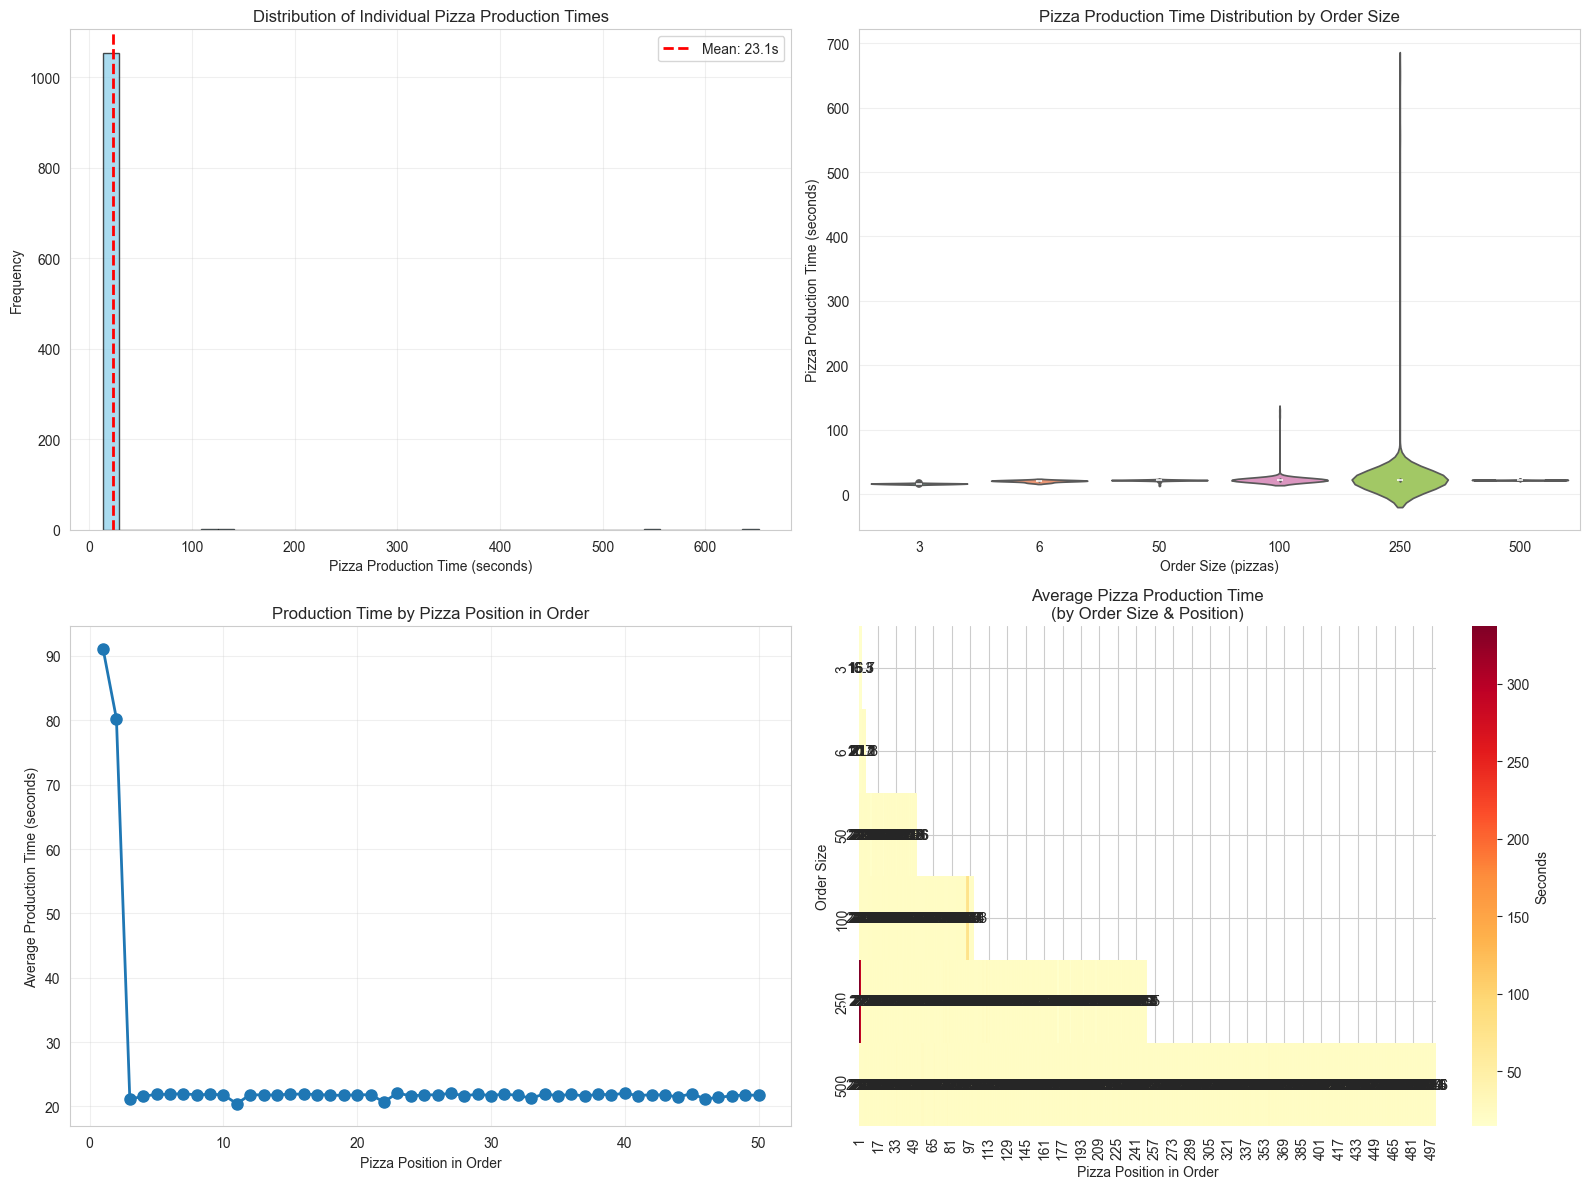

✓ Saved: pizza_analysis_comprehensive.png


In [6]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Pizza latency distribution
axes[0, 0].hist(pizza_enriched['LATENCY_S'], bins=40, edgecolor='black', alpha=0.7, color='skyblue')
axes[0, 0].axvline(pizza_enriched['LATENCY_S'].mean(), color='red', 
                   linestyle='--', linewidth=2, label=f'Mean: {pizza_enriched["LATENCY_S"].mean():.1f}s')
axes[0, 0].set_xlabel('Pizza Production Time (seconds)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Individual Pizza Production Times')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Violin plot by order size
pizza_enriched_sorted = pizza_enriched.sort_values('ORDERSIZE')
sns.violinplot(data=pizza_enriched_sorted, x='ORDERSIZE', y='LATENCY_S', ax=axes[0, 1], palette='Set2')
axes[0, 1].set_xlabel('Order Size (pizzas)')
axes[0, 1].set_ylabel('Pizza Production Time (seconds)')
axes[0, 1].set_title('Pizza Production Time Distribution by Order Size')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Average pizza time within order (position effect)
pizza_enriched['PIZZA_POSITION'] = pizza_enriched.groupby('S_ORDER_ID').cumcount() + 1
position_analysis = pizza_enriched.groupby('PIZZA_POSITION')['LATENCY_S'].agg(['mean', 'count'])
position_analysis = position_analysis[position_analysis['count'] >= 5]  # Only positions with 5+ samples

axes[1, 0].plot(position_analysis.index, position_analysis['mean'], marker='o', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Pizza Position in Order')
axes[1, 0].set_ylabel('Average Production Time (seconds)')
axes[1, 0].set_title('Production Time by Pizza Position in Order')
axes[1, 0].grid(True, alpha=0.3)

# 4. Heatmap: Order size vs Pizza position
if len(pizza_enriched) > 20:
    pivot_data = pizza_enriched.pivot_table(
        values='LATENCY_S', 
        index='ORDERSIZE', 
        columns='PIZZA_POSITION', 
        aggfunc='mean'
    )
    sns.heatmap(pivot_data, annot=True, fmt='.1f', cmap='YlOrRd', ax=axes[1, 1], cbar_kws={'label': 'Seconds'})
    axes[1, 1].set_xlabel('Pizza Position in Order')
    axes[1, 1].set_ylabel('Order Size')
    axes[1, 1].set_title('Average Pizza Production Time\n(by Order Size & Position)')
else:
    axes[1, 1].text(0.5, 0.5, 'Insufficient data for heatmap', 
                    ha='center', va='center', transform=axes[1, 1].transAxes, fontsize=14)
    axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig('pizza_analysis_comprehensive.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: pizza_analysis_comprehensive.png")

## 4. Order vs Pizza Comparison

In [7]:
# Compare total order time vs sum of pizza times
pizza_sum_by_order = pizza_enriched.groupby('S_ORDER_ID')['LATENCY_S'].sum().reset_index()
pizza_sum_by_order.columns = ['ORDERID', 'TOTAL_PIZZA_TIME']

comparison = completed_orders[['ORDERID', 'ORDERSIZE', 'LATENCY_S']].merge(
    pizza_sum_by_order, on='ORDERID', how='inner'
)
comparison['TIME_DIFFERENCE'] = comparison['LATENCY_S'] - comparison['TOTAL_PIZZA_TIME']
comparison['EFFICIENCY_RATIO'] = comparison['TOTAL_PIZZA_TIME'] / comparison['LATENCY_S']

print("=" * 60)
print("ORDER EFFICIENCY ANALYSIS")
print("=" * 60)
print("\nOrders where total pizza time < order time (parallel production):")
print(comparison[comparison['TIME_DIFFERENCE'] > 0][['ORDERID', 'ORDERSIZE', 'TIME_DIFFERENCE', 'EFFICIENCY_RATIO']])

print(f"\nAverage efficiency ratio: {comparison['EFFICIENCY_RATIO'].mean():.2f}")
print(f"(Ratio > 1 indicates sequential production, < 1 indicates parallel production)")

ORDER EFFICIENCY ANALYSIS

Orders where total pizza time < order time (parallel production):
Empty DataFrame
Columns: [ORDERID, ORDERSIZE, TIME_DIFFERENCE, EFFICIENCY_RATIO]
Index: []

Average efficiency ratio: 5.55
(Ratio > 1 indicates sequential production, < 1 indicates parallel production)


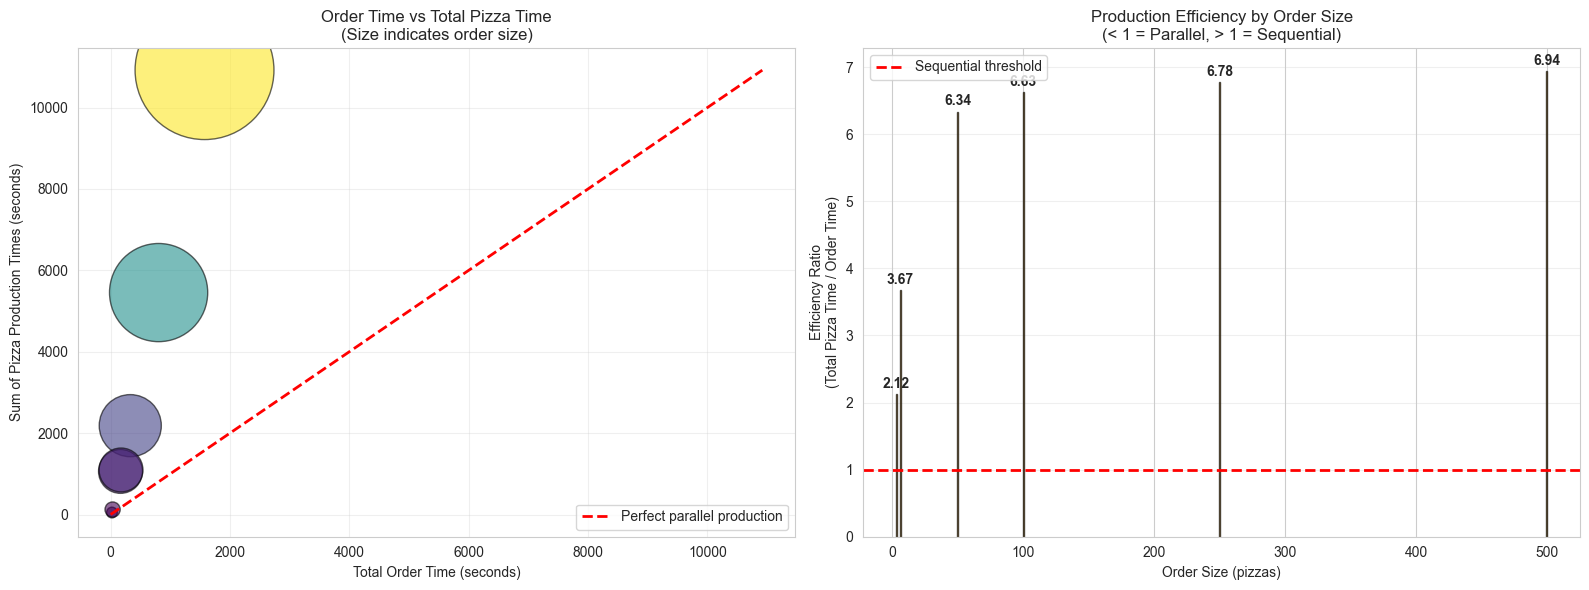

✓ Saved: order_pizza_comparison.png


In [8]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Order time vs sum of pizza times
axes[0].scatter(comparison['LATENCY_S'], comparison['TOTAL_PIZZA_TIME'], 
                s=comparison['ORDERSIZE']*20, alpha=0.6, c=comparison['ORDERSIZE'], 
                cmap='viridis', edgecolors='black')
max_val = max(comparison['LATENCY_S'].max(), comparison['TOTAL_PIZZA_TIME'].max())
axes[0].plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect parallel production')
axes[0].set_xlabel('Total Order Time (seconds)')
axes[0].set_ylabel('Sum of Pizza Production Times (seconds)')
axes[0].set_title('Order Time vs Total Pizza Time\n(Size indicates order size)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Efficiency ratio by order size
efficiency_by_size = comparison.groupby('ORDERSIZE')['EFFICIENCY_RATIO'].mean()
bars = axes[1].bar(efficiency_by_size.index, efficiency_by_size.values, 
                   color=['green' if x < 1 else 'orange' for x in efficiency_by_size.values],
                   edgecolor='black', alpha=0.7)
axes[1].axhline(y=1, color='red', linestyle='--', linewidth=2, label='Sequential threshold')
axes[1].set_xlabel('Order Size (pizzas)')
axes[1].set_ylabel('Efficiency Ratio\n(Total Pizza Time / Order Time)')
axes[1].set_title('Production Efficiency by Order Size\n(< 1 = Parallel, > 1 = Sequential)')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels
for i, (idx, val) in enumerate(efficiency_by_size.items()):
    axes[1].text(idx, val + 0.05, f'{val:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('order_pizza_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: order_pizza_comparison.png")

## 5. Key Findings & Recommendations

In [9]:
print("=" * 70)
print(" " * 20 + "KEY FINDINGS")
print("=" * 70)

# 1. Completion rate
order_completion = len(completed_orders) / len(order_df) * 100
pizza_completion = len(completed_pizzas) / len(pizza_df) * 100
print(f"\n1. COMPLETION RATES:")
print(f"   • Orders: {order_completion:.1f}% completed")
print(f"   • Pizzas: {pizza_completion:.1f}% completed")
if order_completion < 90 or pizza_completion < 90:
    print("   ⚠ WARNING: Low completion rate may indicate system issues")

# 2. Scalability
corr = completed_orders['ORDERSIZE'].corr(completed_orders['LATENCY_S'])
print(f"\n2. SCALABILITY:")
print(f"   • Correlation (size vs time): {corr:.3f}")
if corr > 0.7:
    print("   ⚠ Strong positive correlation - system may not scale well")
elif corr > 0.4:
    print("   ⚠ Moderate correlation - some scalability concerns")
else:
    print("   ✓ Low correlation - good scalability")

# 3. Parallelization
avg_efficiency = comparison['EFFICIENCY_RATIO'].mean()
print(f"\n3. PARALLELIZATION EFFICIENCY:")
print(f"   • Average efficiency ratio: {avg_efficiency:.2f}")
if avg_efficiency > 1.2:
    print("   ⚠ Mostly sequential production - limited parallelization")
elif avg_efficiency > 0.8:
    print("   → Partial parallelization achieved")
else:
    print("   ✓ Good parallelization - efficient use of resources")

# 4. Bottlenecks
largest_orders = completed_orders.nlargest(3, 'ORDERSIZE')
print(f"\n4. POTENTIAL BOTTLENECKS:")
for _, order in largest_orders.iterrows():
    time_per_pizza = order['LATENCY_S'] / order['ORDERSIZE']
    print(f"   • Order {int(order['ORDERID'])} ({int(order['ORDERSIZE'])} pizzas): {time_per_pizza:.1f}s per pizza")

# 5. Recommendations
print(f"\n5. RECOMMENDATIONS:")
if corr > 0.6:
    print("   → Consider adding more parallel processing capacity")
if avg_efficiency > 1.0:
    print("   → Optimize pizza production pipeline for better parallelization")
if pizza_completion < 95:
    print("   → Investigate causes of incomplete pizzas/orders")
if completed_orders['LATENCY_PER_PIZZA'].std() > completed_orders['LATENCY_PER_PIZZA'].mean() * 0.5:
    print("   → High variability in per-pizza time - investigate consistency issues")

print("\n" + "=" * 70)

                    KEY FINDINGS

1. COMPLETION RATES:
   • Orders: 77.8% completed
   • Pizzas: 99.1% completed
   ⚠ WARNING: Low completion rate may indicate system issues

2. SCALABILITY:
   • Correlation (size vs time): 1.000
   ⚠ Strong positive correlation - system may not scale well

3. PARALLELIZATION EFFICIENCY:
   • Average efficiency ratio: 5.55
   ⚠ Mostly sequential production - limited parallelization

4. POTENTIAL BOTTLENECKS:
   • Order 604 (500 pizzas): 3.1s per pizza
   • Order 718 (250 pizzas): 3.2s per pizza
   • Order 271 (100 pizzas): 3.3s per pizza

5. RECOMMENDATIONS:
   → Consider adding more parallel processing capacity
   → Optimize pizza production pipeline for better parallelization



## 6. Export Results

In [10]:
# Export summary statistics
with open('analysis_summary.txt', 'w') as f:
    f.write("PIZZA PRODUCTION ANALYSIS SUMMARY\n")
    f.write("=" * 50 + "\n\n")
    f.write(f"Total Orders: {len(order_df)}\n")
    f.write(f"Completed Orders: {len(completed_orders)}\n")
    f.write(f"Total Pizzas: {len(pizza_df)}\n")
    f.write(f"Completed Pizzas: {len(completed_pizzas)}\n\n")
    f.write(f"Average Order Time: {completed_orders['LATENCY_S'].mean():.2f}s\n")
    f.write(f"Average Pizza Time: {pizza_enriched['LATENCY_S'].mean():.2f}s\n")
    f.write(f"Efficiency Ratio: {avg_efficiency:.2f}\n")
    f.write(f"Size-Time Correlation: {corr:.3f}\n")

print("✓ Saved: analysis_summary.txt")

# Export detailed data
comparison.to_csv('order_efficiency_analysis.csv', index=False)
print("✓ Saved: order_efficiency_analysis.csv")

print("\n✅ Analysis complete! All visualizations and summaries have been generated.")

✓ Saved: analysis_summary.txt
✓ Saved: order_efficiency_analysis.csv

✅ Analysis complete! All visualizations and summaries have been generated.
